Importing the necessary libraries needed for the project

In [289]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.spatial.distance import cdist
import statsmodels
from datetime import datetime 
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

In [290]:
# filter unwanted warning
warnings.filterwarnings('ignore')

Loading and visualizing the data

In [291]:
df = pd.read_csv('PT_Train.csv')

In [292]:
df.head()

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0


In [293]:
# Dropping Lifetouch Respiration Rate, Oximeter SpO2 and Oximeter Pulse since our focus is only on Lifetouch Heart Rate
df = df.drop(columns=["Lifetouch Respiration Rate","Oximeter SpO2","Oximeter Pulse"], axis=1, inplace=False)

In [294]:
df.head()

,Timestamp (GMT),Lifetouch Heart Rate
0,17/08/2015 15:09,139
1,17/08/2015 15:10,144
2,17/08/2015 15:11,140
3,17/08/2015 15:12,138
4,17/08/2015 15:13,133


In [295]:
#Converting Minute to integer
df["Minutes-No"]= list(range(0,len(df["Timestamp (GMT)"])))

In [296]:
#Converting the data type and indexing datetime
con=df['Timestamp (GMT)']
df['Timestamp (GMT)']=pd.to_datetime(df['Timestamp (GMT)'])
df.set_index('Timestamp (GMT)', inplace=True)

In [297]:
df.head()

,Lifetouch Heart Rate,Minutes-No
Timestamp (GMT),,
2015-08-17 15:09:00,139,0
2015-08-17 15:10:00,144,1
2015-08-17 15:11:00,140,2
2015-08-17 15:12:00,138,3
2015-08-17 15:13:00,133,4


In [298]:
df.describe()

,Lifetouch Heart Rate,Minutes-No
count,226.000000,226.000000
mean,2315.615044,112.500000
std,11351.588825,65.384759
min,106.000000,0.000000
25%,136.000000,56.250000
50%,145.000000,112.500000
75%,156.000000,168.750000
max,61442.000000,225.000000


In [299]:
#Data preprocessing
# find if the DataFrame contains Null/NaN values
df.isna().sum()

Lifetouch Heart Rate    0
Minutes-No              0
dtype: int64

In [300]:
# check the columns having "?"
df[df == '?'].count()

Lifetouch Heart Rate    0
Minutes-No              0
dtype: int64

In [301]:
#Replacing the outliers with the mean
df1= df.copy()
df1.drop(df1[df1['Lifetouch Heart Rate'] > 500].index, inplace = True)
mean = df1['Lifetouch Heart Rate'].mean()
df['Lifetouch Heart Rate'] = np.where(df['Lifetouch Heart Rate'] > 500, mean, df['Lifetouch Heart Rate'])
print(mean)

145.86238532110093


In [302]:
df.describe()

,Lifetouch Heart Rate,Minutes-No
count,226.000000,226.000000
mean,145.862385,112.500000
std,11.129115,65.384759
min,106.000000,0.000000
25%,136.000000,56.250000
50%,144.931193,112.500000
75%,155.000000,168.750000
max,172.000000,225.000000


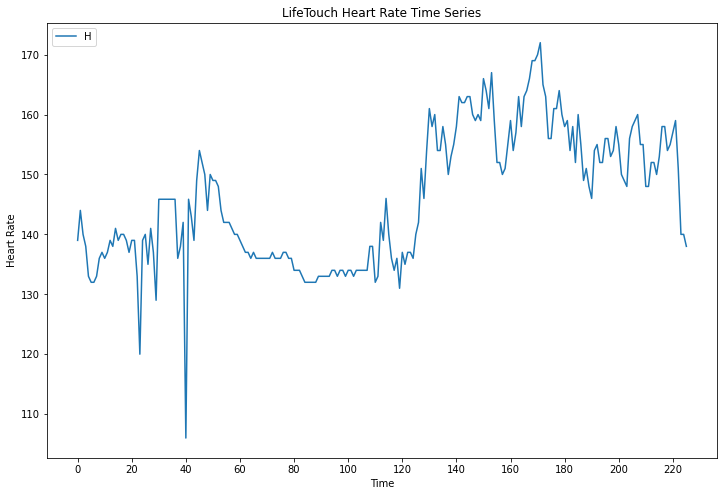

In [303]:
#Plot the time series
plt.figure(figsize=(12, 8))
plt.plot(df["Minutes-No"], df['Lifetouch Heart Rate'])
plt.xticks(np.arange(min(df["Minutes-No"]), max(df["Minutes-No"])+1, 20))
plt.legend(labels="HeartRate", loc=2)
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("LifeTouch Heart Rate Time Series")
plt.show()

In [304]:
# checking for stationarity of the series with KPSS

def check_stationarity(series):
  statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(series)
  print(f'p value: {p_value}')
  print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary \n')
check_stationarity(df['Lifetouch Heart Rate'])

p value: 0.01
Result: The series is not stationary 



In [305]:
# checking for stationarity of the series with ADF test

from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['Lifetouch Heart Rate'])
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(df):
    result=adfuller(df)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(df['Lifetouch Heart Rate'])

ADF Test Statistic : -2.3134232628478246
p-value : 0.16767524300113734
#Lags Used : 3
Number of Observations Used : 222
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


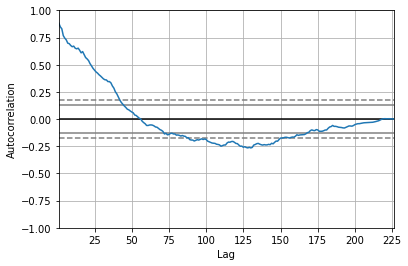

In [306]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Lifetouch Heart Rate'])
plt.show()

To make the series stationary and removing seasionarity

In [307]:
#Log Transformation of the Heart Rate
df['Log-LHR'] = np.log(df['Lifetouch Heart Rate']) 

df.head()

,Lifetouch Heart Rate,Minutes-No,Log-LHR
Timestamp (GMT),,,
2015-08-17 15:09:00,139.0,0,4.934474
2015-08-17 15:10:00,144.0,1,4.969813
2015-08-17 15:11:00,140.0,2,4.941642
2015-08-17 15:12:00,138.0,3,4.927254
2015-08-17 15:13:00,133.0,4,4.890349


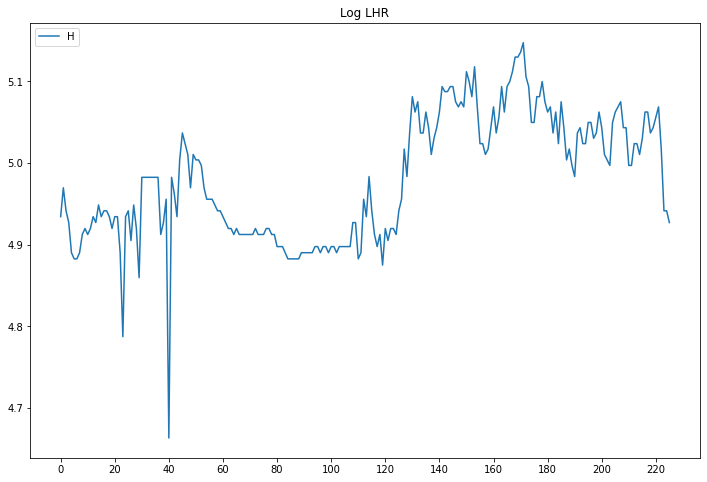

In [308]:
#Log-LHR plot

plt.figure(figsize=(12, 8))
plt.plot(df["Minutes-No"], df['Log-LHR'])
plt.xticks(np.arange(min(df["Minutes-No"]), max(df["Minutes-No"])+1, 20))
plt.legend(labels="HeartRate", loc=2)
plt.title("Log LHR")
plt.show()

In [309]:
#Deseasonalization

df['Deseasonalised-LHR'] = df[['Log-LHR']].diff(axis=0, periods=12)
df.head(15)

,Lifetouch Heart Rate,Minutes-No,Log-LHR,Deseasonalised-LHR
Timestamp (GMT),,,,
2015-08-17 15:09:00,139.0,0,4.934474,NaN
2015-08-17 15:10:00,144.0,1,4.969813,NaN
2015-08-17 15:11:00,140.0,2,4.941642,NaN
2015-08-17 15:12:00,138.0,3,4.927254,NaN
2015-08-17 15:13:00,133.0,4,4.890349,NaN
2015-08-17 15:14:00,132.0,5,4.882802,NaN
2015-08-17 15:15:00,132.0,6,4.882802,NaN
2015-08-17 15:16:00,133.0,7,4.890349,NaN
2015-08-17 15:17:00,136.0,8,4.912655,NaN


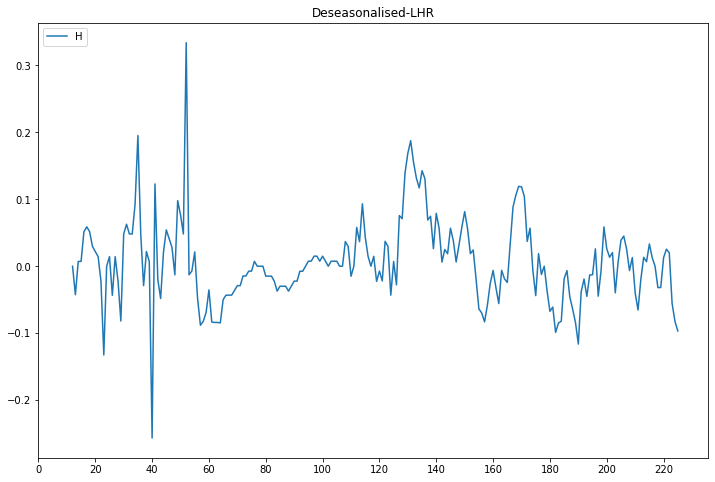

In [310]:
#Deseasonalised Plot

plt.figure(figsize=(12, 8))
plt.plot(df["Minutes-No"], df['Deseasonalised-LHR'])
plt.xticks(np.arange(min(df["Minutes-No"]), max(df["Minutes-No"])+1, 20))
plt.legend(labels="HeartRate", loc=2)
plt.title("Deseasonalised-LHR")
plt.show()

In [311]:
# Differencing

df['Differenced-LHR'] = df[['Deseasonalised-LHR']].diff(axis=0, periods=1)
df.tail(15)

,Lifetouch Heart Rate,Minutes-No,Log-LHR,Deseasonalised-LHR,Differenced-LHR
Timestamp (GMT),,,,,
2015-08-17 18:40:00,148.0,211,4.997212,-0.065383,-0.025642
2015-08-17 18:41:00,152.0,212,5.023881,-0.019545,0.045838
2015-08-17 18:42:00,152.0,213,5.023881,0.013245,0.032790
2015-08-17 18:43:00,150.0,214,5.010635,0.006689,-0.006556
2015-08-17 18:44:00,153.0,215,5.030438,0.033226,0.026537
2015-08-17 18:45:00,158.0,216,5.062595,0.012739,-0.020487
2015-08-17 18:46:00,158.0,217,5.062595,0.000000,-0.012739
2015-08-17 18:47:00,154.0,218,5.036953,-0.031952,-0.031952
2015-08-17 18:48:00,155.0,219,5.043425,-0.031749,0.000203


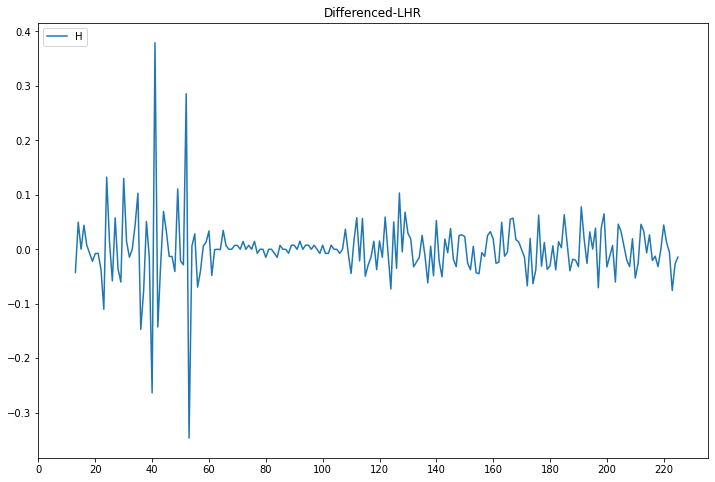

In [312]:
# Differenced-LHR plot

plt.figure(figsize=(12, 8))
plt.plot(df["Minutes-No"], df['Differenced-LHR'])
plt.xticks(np.arange(min(df["Minutes-No"]), max(df["Minutes-No"])+1, 20))
plt.legend(labels="HeartRate", loc=2)
plt.title("Differenced-LHR")
plt.show()

In [313]:
## Again KPSS test for stationarity

check_stationarity(df['Differenced-LHR'][13:])

p value: 0.1
Result: The series is stationary 



In [314]:
## Again dickey fuller test for stationarity
adfuller_test(df['Differenced-LHR'][13:])

ADF Test Statistic : -7.43731942309769
p-value : 6.134605892405097e-11
#Lags Used : 12
Number of Observations Used : 200
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


Auto Regressive Model

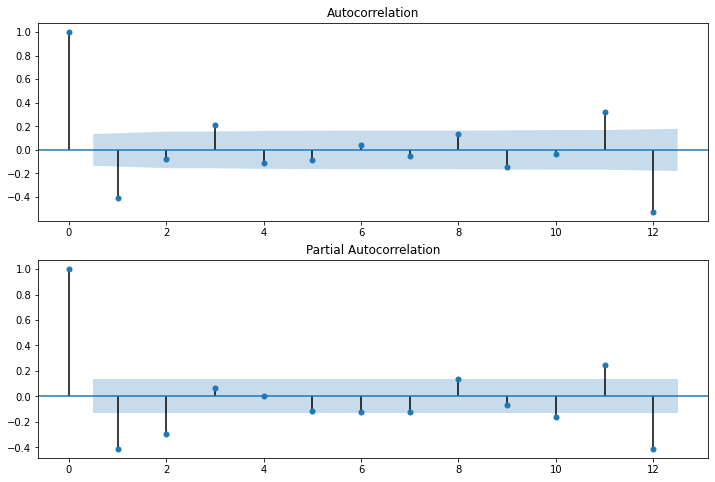

In [315]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Differenced-LHR'].iloc[13:],lags=12,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Differenced-LHR'].iloc[13:],lags=12,ax=ax2)

In [316]:
# order - The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
# seasonal_order - The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
model = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
                                  order=(0, 0, 1),
                                  seasonal_order=(0, 0, 0, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
# train model
model_fit = model.fit()
print(model_fit.summary())

                            Statespace Model Results                            
Dep. Variable:     Lifetouch Heart Rate   No. Observations:                  226
Model:                 SARIMAX(0, 0, 1)   Log Likelihood               -1285.209
Date:                  Fri, 18 Feb 2022   AIC                           2574.417
Time:                          13:59:15   BIC                           2581.241
Sample:                      08-17-2015   HQIC                          2577.171
                           - 08-17-2015                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0000     35.975      0.028      0.978     -69.511      71.511
sigma2      5503.4623   1.97e+05      0.028      0.978    -3.8e+05    3.91e+05
Ljung-Box (Q):                     1

In [317]:
# make predictions
preds = model_fit.predict(start=pd.to_datetime('2015-08-17 17:55:00'), end=pd.to_datetime('2015-08-17 18:54:00'), dynamic=False)
print(preds)

2015-08-17 17:55:00    82.256627
2015-08-17 17:56:00    81.250960
2015-08-17 17:57:00    84.241578
2015-08-17 17:58:00    84.253924
2015-08-17 17:59:00    84.244636
2015-08-17 18:00:00    85.250937
2015-08-17 18:01:00    86.241775
2015-08-17 18:02:00    78.300343
2015-08-17 18:03:00    84.210079
2015-08-17 18:04:00    71.377348
2015-08-17 18:05:00    84.139109
2015-08-17 18:06:00    76.424195
2015-08-17 18:07:00    84.097990
2015-08-17 18:08:00    79.453136
2015-08-17 18:09:00    80.096895
2015-08-17 18:10:00    77.470323
2015-08-17 18:11:00    81.079251
2015-08-17 18:12:00    72.520098
2015-08-17 18:13:00    85.012813
2015-08-17 18:14:00    66.623137
2015-08-17 18:15:00    92.872138
2015-08-17 18:16:00    61.793851
2015-08-17 18:17:00    86.739819
2015-08-17 18:18:00    63.918381
2015-08-17 18:19:00    83.636755
2015-08-17 18:20:00    62.035026
2015-08-17 18:21:00    91.483495
2015-08-17 18:22:00    63.185699
2015-08-17 18:23:00    88.354136
2015-08-17 18:24:00    63.317801
2015-08-17

In [318]:
p = d = q = range(0, 3)

# generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(1, 1, 1, 12)]

for param in pdq:
    for param_seasonal in seasonal_pdq:
          mod = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
                                          order=param,
                                          seasonal_order=param_seasonal,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

          mod_fit = mod.fit()

          print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, mod_fit.aic))

ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1451.4779180910155
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1368.2168976244434
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:1341.471712605175
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1284.1988250047714
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1247.628599510941
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:1243.336471813433
ARIMA(0, 2, 0)x(1, 1, 1, 12)12 - AIC:1462.3394556628164
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:1266.672111410879
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:1233.0793739054961
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1268.2507406215036
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1252.694523281149
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:1247.9139053587655
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1248.2312976284002
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1249.6284559705703
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:1243.9241463791982
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:1373.9285323799595
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:1244.046169408604
ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:1235.055955650247

In [331]:
# order - The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters.
# seasonal_order - The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity.
model = sm.tsa.statespace.SARIMAX(df['Lifetouch Heart Rate'],
                                  order=(2, 1, 2),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
# train model
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:               Lifetouch Heart Rate   No. Observations:                  226
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood                -608.222
Date:                            Fri, 18 Feb 2022   AIC                           1230.443
Time:                                    15:59:27   BIC                           1253.461
Sample:                                08-17-2015   HQIC                          1239.760
                                     - 08-17-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7764      0.234     -3.314      0.001      -1.236      -0.317
ar.L2         -0.4554      0.192   

In [320]:
# make predictions
preds = model_fit.predict(start=pd.to_datetime('2015-08-17 17:55:00'), end=pd.to_datetime('2015-08-17 18:54:00'), dynamic=False)
print(preds)

# calculate RMSE
actuals = df["Lifetouch Heart Rate"]
actuals = actuals.loc["2015-08-17 17:55:0":"2015-08-17 18:54:00"]
print(f'Root Mean Squared Error: {round(np.sqrt(mean_squared_error(actuals, preds)), 2)}')

2015-08-17 17:55:00    162.680448
2015-08-17 17:56:00    159.726088
2015-08-17 17:57:00    166.418125
2015-08-17 17:58:00    166.941401
2015-08-17 17:59:00    168.089484
2015-08-17 18:00:00    170.264620
2015-08-17 18:01:00    169.564790
2015-08-17 18:02:00    167.914331
2015-08-17 18:03:00    167.250840
2015-08-17 18:04:00    159.948777
2015-08-17 18:05:00    156.952252
2015-08-17 18:06:00    160.263002
2015-08-17 18:07:00    160.667257
2015-08-17 18:08:00    161.757629
2015-08-17 18:09:00    161.833960
2015-08-17 18:10:00    159.162833
2015-08-17 18:11:00    158.007179
2015-08-17 18:12:00    156.062684
2015-08-17 18:13:00    155.561135
2015-08-17 18:14:00    153.051960
2015-08-17 18:15:00    159.550930
2015-08-17 18:16:00    156.484717
2015-08-17 18:17:00    153.432061
2015-08-17 18:18:00    152.382666
2015-08-17 18:19:00    148.730527
2015-08-17 18:20:00    145.787961
2015-08-17 18:21:00    151.383890
2015-08-17 18:22:00    152.680161
2015-08-17 18:23:00    153.278772
2015-08-17 18:

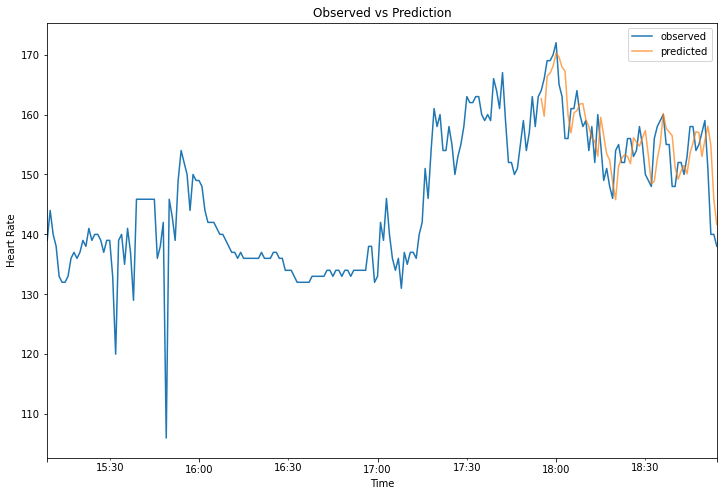

In [321]:
# plot observations and predictions
ax = df["Lifetouch Heart Rate"].plot(label='observed', figsize=(12, 8))
preds.plot(ax=ax, label='predicted', alpha=.7)

ax.set_xlabel('Time')
ax.set_ylabel('Heart Rate')
plt.legend()
plt.title("Observed vs Prediction")
plt.show()

In [322]:
# Forecasting beyond the sample
forecasts = model_fit.forecast(steps=20)
print(forecasts)

2015-08-17 18:55:00    137.488771
2015-08-17 18:56:00    137.368578
2015-08-17 18:57:00    139.193077
2015-08-17 18:58:00    138.561571
2015-08-17 18:59:00    137.752699
2015-08-17 19:00:00    139.097356
2015-08-17 19:01:00    136.870796
2015-08-17 19:02:00    137.849771
2015-08-17 19:03:00    137.282758
2015-08-17 19:04:00    136.614057
2015-08-17 19:05:00    136.910739
2015-08-17 19:06:00    137.550025
2015-08-17 19:07:00    137.007851
2015-08-17 19:08:00    136.234328
2015-08-17 19:09:00    138.580143
2015-08-17 19:10:00    137.841395
2015-08-17 19:11:00    136.878368
2015-08-17 19:12:00    138.391577
2015-08-17 19:13:00    136.104338
2015-08-17 19:14:00    137.053626
Freq: T, dtype: float64


In [323]:
forecasts = pd.DataFrame(data=forecasts,columns=["Forecasted Heart Rate"])
forecasts

,Forecasted Heart Rate
2015-08-17 18:55:00,137.488771
2015-08-17 18:56:00,137.368578
2015-08-17 18:57:00,139.193077
2015-08-17 18:58:00,138.561571
2015-08-17 18:59:00,137.752699
2015-08-17 19:00:00,139.097356
2015-08-17 19:01:00,136.870796
2015-08-17 19:02:00,137.849771
2015-08-17 19:03:00,137.282758
2015-08-17 19:04:00,136.614057


In [324]:
forecasts.to_csv('Forecast(20 minutes).csv')

In [325]:
forecasts["Minutes-No"]= list(range(226,246))
forecasts

,Forecasted Heart Rate,Minutes-No
2015-08-17 18:55:00,137.488771,226
2015-08-17 18:56:00,137.368578,227
2015-08-17 18:57:00,139.193077,228
2015-08-17 18:58:00,138.561571,229
2015-08-17 18:59:00,137.752699,230
2015-08-17 19:00:00,139.097356,231
2015-08-17 19:01:00,136.870796,232
2015-08-17 19:02:00,137.849771,233
2015-08-17 19:03:00,137.282758,234
2015-08-17 19:04:00,136.614057,235


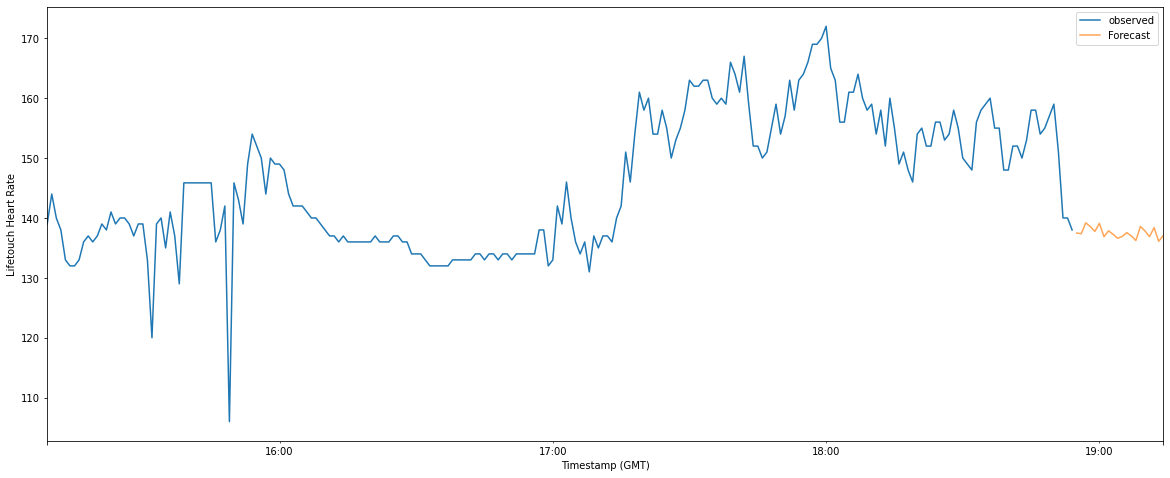

In [329]:
# plotting code
ax = df["Lifetouch Heart Rate"].plot(label='observed', figsize=(20, 8))
forecasts["Forecasted Heart Rate"].plot(ax=ax, label='Forecast', alpha=.7)

ax.set_ylabel('Lifetouch Heart Rate')

plt.legend()

plt.show()